In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib as mpl
import matplotlib.cm as cm

%matplotlib inline

In [3]:
fname = '../../data/analysis/within_vs_between_beta.braycurtis.txt'
df = pd.read_csv(fname, sep='\t')
df.head()

,subject,site,sample,site_comparison,n_btw_patient,n_lower,within_beta,mean_inter_beta,median_inter_beta,percent_lower
0,01-112-7,throat_swab,01-112-7TI,gastric_fluid-throat_swab,51,51,0.994299,0.667426,0.647226,1.000000
1,01-112-7,gastric_fluid,01-112-7GI,gastric_fluid-throat_swab,42,13,0.994299,0.987776,0.994613,0.309524
2,01-164-7,throat_swab,01-164-7TI,gastric_fluid-throat_swab,51,0,0.180313,0.715014,0.679061,0.000000
3,01-164-7,gastric_fluid,01-164-7GI,gastric_fluid-throat_swab,42,0,0.180313,0.815129,0.830430,0.000000
4,01-173-4,gastric_fluid,01-173-4G,gastric_fluid-throat_swab,42,2,0.505004,0.759655,0.747293,0.047619


In [4]:
df['inter_minus_intra'] = df['mean_inter_beta'] - df['within_beta']

In [5]:
df.groupby(['site_comparison', 'site']).size()

site_comparison            site         
bal-gastric_fluid          bal               89
                           gastric_fluid     89
bal-throat_swab            bal               73
                           throat_swab       73
gastric_fluid-throat_swab  gastric_fluid    112
                           throat_swab      112
dtype: int64

# Paired slope graph

In words, this plot shows the within-patient beta diversity (left points) across two different sites (each panel), as compared to the average across-patient beta diversity (right points) between each of the sites in the within-comparison (the two slope graphs on each panel).

In maybe better words, here's what we're showing:

- each panel is a different type of within-patient comparison
- each slope graph is a different type of across-patient comparison for a given within-patient comparison
- each point corresponds to a patient
- the left points are that patient's within-patient JSD
- the right points are the average JSD between that patient's site X and all other patients' site X
    - each panel has two site X's, one for each in the within-patient comparison

As a reminder, a lower y-value means that communities are more similar.

Upward sloping (red) lines indicate that the two different communities are *more similar* within that patient than the average of that patient's given site with all other patient's same site.



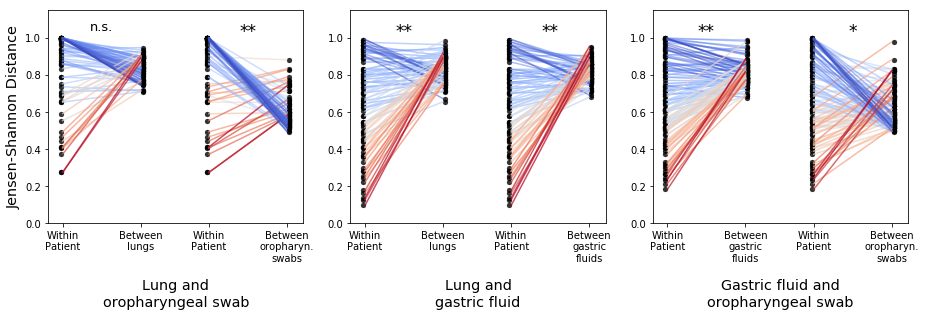

In [9]:
site_lbl_dict = {
    'bal': 'lungs\n',
    'throat_swab': 'oropharyn.\nswabs',
    'gastric_fluid': 'gastric\nfluids'
}
site_comp_dict = {
    'bal-throat_swab': 'Lung and\noropharyngeal swab',
    'bal-gastric_fluid': 'Lung and\ngastric fluid',
    'gastric_fluid-throat_swab': 'Gastric fluid and\noropharyngeal swab'
}

pval_dict = {'bal-throat_swab/bal': 'n.s.',
             'bal-throat_swab/throat_swab': '**',
             'bal-gastric_fluid/bal': '**',
             'bal-gastric_fluid/gastric_fluid': '**',
             'gastric_fluid-throat_swab/gastric_fluid': '**',
             'gastric_fluid-throat_swab/throat_swab': '*'}

fig, ax = plt.subplots(1, 3, figsize=(13, 4.5))

i = 0
# Manually enocde these so the order matches the rest of paper
site_comparisons = ['bal-throat_swab', 'bal-gastric_fluid', 'gastric_fluid-throat_swab']

for site_comp in site_comparisons:
    subdf = df.query('site_comparison == @site_comp')
    xi = 0
    allxs = []
    all_xlabels = []
    for site, site_subdf in subdf.groupby('site'):
        # Sort the dataframe by absolute value of the difference, so that
        # the bigger differences are plotted last (i.e. top of the layers)
        site_subdf.loc[site_subdf.index, 'abs_inter_minus_intra'] = (
            site_subdf['inter_minus_intra'].abs())
        site_subdf = site_subdf.sort_values(by='abs_inter_minus_intra')

        # These are the two sets of y-values, paired
        beta_within = site_subdf['within_beta'].values
        beta_between = site_subdf['mean_inter_beta'].values

        # Set up color from the dataframe
        # Note: making this symmetric still looks super washed out
#        # Get maximum difference (absolute value)
#        max_diff = site_subdf['inter_minus_intra'].abs().max()
        vmax = site_subdf['inter_minus_intra'].max()
        vmin = site_subdf['inter_minus_intra'].min()
        
        # Make normalized colormap
        norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
        #cmap = sns.diverging_palette(220,20,as_cmap=True)
        cmap = cm.get_cmap('coolwarm')
        m = cm.ScalarMappable(norm=norm, cmap=cmap)

        c = site_subdf['inter_minus_intra'].apply(m.to_rgba)

        # And set up alpha values for the lines 
        # blue should be more transparent (lower alpha) bc it's visually darker
        alphas = [0.7 if j > 0  else 0.5 for j in site_subdf['inter_minus_intra'].values]
        
        # The 0.2 changes how far apart the dots are for one comparison
        slope_space = 0.2
        x1 = xi - slope_space
        x2 = xi + slope_space

        # Plot the lines connecting the dots
        for withini, betweeni, ci, ai in zip(beta_within, beta_between, c, alphas):
            ax[i].plot([x1, x2], [withini, betweeni], c=ci, alpha=ai)

        ax[i].scatter(len(beta_within)*[x1-0.01], beta_within, 
            s=25, linewidths=0.25, edgecolor='k', 
            c='k', alpha=0.8)
        ax[i].scatter(len(beta_between)*[x2+0.01], beta_between, 
            s=25, linewidths=0.25, edgecolor='k', 
            c='k', alpha=0.8)
        
        allxs += [x1, x2]
        all_xlabels += ['Within\nPatient\n\n', 
                        'Between\n' + site_lbl_dict[site]]
        
        # Add pvalue asterisk
        x_pval = x1 + (x2 - x1)/2.0
        txt_pval = pval_dict[site_comp + '/' + site]
        if txt_pval == "n.s.":
            fs = 13
            y = 1.04
        else:
            fs = 17
            y = 1.008
        ax[i].text(x_pval, y, txt_pval, 
                   fontsize=fs, ha='center')
        
        # This one changes how far apart each pair of points is in an aixs
        xi += 0.75

    ax[i].set_xticks(allxs)   
    ax[i].set_xticklabels(all_xlabels)
        
    ax[i].set_xlabel(site_comp_dict[site_comp], fontsize='x-large')

    ax[i].set_ylim([0, 1.15])
    if i == 0:
        ax[i].set_ylabel('Bray-Curtis distance', fontsize='x-large')

    i += 1

fig.tight_layout()
fig.savefig('../../final/figures/suppfig.within_pt_vs_between_pt.braycurtis.png', dpi=200)

In the caption, I think I will directly explain how to interpret each panel.

Left panel: lung and oropharyngeal microbiomes within people are more different from each other than oropharyngeal microbiomes are across people. Middle panel: lung and stomach microbiomes are more similar within people than lungs and stomachs are across people. Right panel: oropharyngeal and stomach microbiomes within people are more similar than stomachs across people.

## P values

We'll do a paired wilcoxon. From [scipy.stats.wilcoxon](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.wilcoxon.html):

```
The Wilcoxon signed-rank test tests the null hypothesis that two related paired samples come from the same distribution. In particular, it tests whether the distribution of the differences x - y is symmetric about zero. It is a non-parametric version of the paired T-test.
```

We'll also calculate the direction of the effect.

In [7]:
from scipy.stats import wilcoxon
pval_res = []
for site_comp in site_comparisons:
    subdf = df.query('site_comparison == @site_comp')

    for site, site_subdf in subdf.groupby('site'):

        # These are the two sets of y-values, paired
        beta_within = site_subdf['within_beta'].values
        beta_between = site_subdf['mean_inter_beta'].values
        w, p = wilcoxon(beta_within, beta_between)
        
        if np.mean(beta_within) > np.mean(beta_between):
            lbl = 'within > between'
        else:
            lbl = 'within < between'

        pval_res.append([site_comp, site, p, lbl, w])
pval_df = pd.DataFrame(pval_res, 
    columns=['within pt comparison', 'between pt site', 'p value', 'direction', 'test stat'])
pval_df

,within pt comparison,between pt site,p value,direction,test stat
0,bal-throat_swab,bal,8.090239e-02,within > between,1033.0
1,bal-throat_swab,throat_swab,2.945417e-09,within > between,271.0
2,bal-gastric_fluid,bal,1.584525e-08,within < between,621.0
3,bal-gastric_fluid,gastric_fluid,6.319929e-07,within < between,785.0
4,gastric_fluid-throat_swab,gastric_fluid,1.810847e-08,within < between,1225.0
5,gastric_fluid-throat_swab,throat_swab,4.484972e-02,within > between,2473.0


Lung and throat microbiomes within people:
- similarly different as lungs across people
- more different than throats across people


Lung and stomach microbiomes within people:
- more similar than lungs across people
- more similar than stomachs across people

Throat and stomach microbiomes within people:
- more similar than stomachs across people
- similarly different as throats across people